In [67]:
import os
import numpy as np
from pathlib import Path
import imageio
import random
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

In [68]:
class FolderImageDataset():
    def __init__(self, paths,
                 filtered = None, names = None, N_COMPONENTS = 150, pca = None):
        """
        Reads images from folder and optionally applies a transform to them.
        Filter parameter takes target value and returns bool

        Parameters
        ----------
        folder : str
        start: float
            rel index of start. float from 0 to 1.
        end: float
            rel index of end. float from 0 to 1.
        transfrom : callable
            lazily apply transform to image.
        filtered: callable
            float ->  bool. filters the dataset based on target
        """
        
        
        self.names = names
        self.paths = paths
        self.N_COMPONENTS = N_COMPONENTS
    
        
        self.images = []
        self.target = []
        if pca:
            self.pcas = pca
            index = 0
        else:
            index = None
            self.pcas = []
        
        for path, names in zip(self.paths, self.names):
            target, images, pca_0 = self.get_pca_of_images(self.N_COMPONENTS, names, path, filtered = filtered, pca = index)
            self.target.append(target)
            self.images.append(images)
            if not pca:
                self.pcas.append(pca_0)
            else :
                index += 1
        i = 0
        
        for target, images in zip(self.target, self.images):
            self.target[i], self.images[i] = self.get_average_data(target, images)
            i += 1
            
            
        new_target = self.make_final_target(self.target)
        new_images = np.zeros((len(new_target), len(self.target)*self.N_COMPONENTS))
        idxs = np.zeros(len(self.target), dtype = int)
        for i, phase in enumerate(new_target):
            im, idxs = self.join_images(self.target, self.images, idxs, phase)
            new_images[i] = im
        self.target = new_target
        self.images = new_images
        
        
 
    def __len__(self):
        return  len(self.target)
    
    
    def get_pca_of_images(self,N_COMPONENTS, names, path, filtered = None, pca = None):
        images = []
        target = []
        for item in names:
            images.append(np.array(imageio.imread(str(path/item))))
            target.append(float(item.split("_")[1]))
        images = np.array(images)
        target = np.array(target)
        
        # filter the images
        if filtered:
            images = images[filtered(target)]
            target = target[filtered(target)]
        if not pca:
            pca = PCA(N_COMPONENTS)
            pca.fit(self.data_transform(images))
        else:
            pca = self.pcas[pca]
        images = np.array(pca.transform(self.data_transform(images)), dtype = float)
        return target, images, pca
    
    def data_transform(self, images):
        return np.array(images).reshape(len(images), -1)  
    
    def print_target_statistic(self):
        print(f"MEAN = {self.target.mean()} \t MSE = {self.target.std()**2} \t SIGMA = {self.target.std()}")
        
    def get_items(self,target, images, idx):
        a = target[idx]
        b = np.zeros(len(images[idx]))
        cnt = 0
        while idx+cnt < len(target) and target[idx+cnt] == a :
            b += images[idx+cnt]
            cnt += 1
        b = b/cnt
        return a, b, idx+cnt
        
    def get_average_data(self, target, images):
        new_target = []
        new_images = []
        idx = 0
        while idx < len(target):
            a, b, idx = self.get_items(target, images, idx)
            new_target.append(a)
            new_images.append(b)
        return np.array(new_target), np.array(new_images)
    
    def join_images(self, target, images, idxs, phase):
        result = []
        for i, item in enumerate(target):
            while True:
                if idxs[i] >= len(item):
                    idxs[i] = 0
                
                if item[idxs[i]] != phase:
                    idxs[i] += 1
                else:
                    break
            result.append(images[i][idxs[i]])
        result = np.array(result).flatten()
        
        return result, idxs
    
    
    
    
    def make_final_target(self, target):
        minimum = np.array([item[0] for item in target]).min()
        lenths = np.array([len(item) for item in target]).min()
        result = np.array(target[np.where(lenths == lenths.min())[0][0]])
        result = result[np.where(result == minimum)[0][0]:]
        return result
        

# Get Data


In [69]:
def split(names, shuffle = False, test_size = 0.2, start = 0, end = 1):
    names = np.array(names)
    idx = np.linspace(start*(len(names)-1),end*(len(names)-1), len(names), dtype = int)
    if shuffle:
        random.shuffle(idx)

    return names[idx[:int((1-test_size)*len(idx))]], names[idx[:int((test_size)*len(idx))]]

def get_valid_names(path):
    names = os.listdir(path)

    need = lambda x: ".png" in x
    names = list(filter(need, names))

    names.sort(key= lambda x: int(x.split("_")[0]))

    k = 0

    for i in range(len(names)):
        if names[i+1].split("_")[1] < names[i].split("_")[1]:
            k = i
            break

    names = names[k+1:]
    for i in range(len(names)-1, 0, -1):
        if names[i-1].split("_")[1] > names[i].split("_")[1]:
            k = i
            break

    names = names[:k-1]
    return names

def train_test(paths, N_COMPONENTS, filtered = None, 
               start = 0, end = 1, shuffle = False, test_size = 0.2):
    
    names = []
    for path in paths:
        names.append(get_valid_names(path))

    names = np.array(names)
    train_names = []
    test_names = []

    for item in names:
        train, test = split(item, start = start, end = end, shuffle = shuffle, test_size = test_size)
        train_names.append(train)
        test_names.append(test)

    train_dataset = FolderImageDataset(paths, filtered = filtered, 
                                       names = train_names, N_COMPONENTS = N_COMPONENTS) 
    test_dataset = FolderImageDataset(paths, filtered = filtered, 
                                       names = test_names, N_COMPONENTS = N_COMPONENTS, pca = train_dataset.pcas)
    
    return train_dataset, test_dataset

In [70]:
def condition(a):
    # based on dataset inspection plots
    return (0.120 > a) & (a > 0.105)

In [71]:
N_COMPONENTS = 50;
paths = [
    Path("img5_stripes/2/"),
    Path("img5_stripes/3/"),
      Path("img4_stripes/")
]

In [72]:
train_dataset, test_dataset = train_test(paths, N_COMPONENTS, filtered = condition) 


# Random Forest and Ensamble

In [49]:
import sklearn
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn import tree
from sklearn import ensemble
from matplotlib import pylab
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [31]:
random_forest = tree.DecisionTreeRegressor()

In [32]:
cross_score_ans_1 = cross_val_score(random_forest, train_dataset.images, train_dataset.target, cv = 10)

In [33]:
cross_score_ans_1.mean()

0.9315612646669298

In [34]:
cross_score_ans_1

array([0.66719831, 0.9267071 , 0.9970599 , 0.99733813, 0.83144778,
       0.99690614, 0.99693716, 0.93821126, 0.9680399 , 0.99576698])

In [35]:
random_forest_2 = ensemble.BaggingRegressor(random_forest, n_estimators = 100)

In [36]:
cross_score_ans_2 = cross_val_score(random_forest_2, train_dataset.images, train_dataset.target, cv = 10)

In [37]:
cross_score_ans_2

array([0.79071405, 0.97931094, 0.99794856, 0.99784359, 0.98861662,
       0.99725249, 0.98646196, 0.93231003, 0.89109489, 0.99218106])

In [38]:
cross_score_ans_2.mean()

0.955373420123464

In [44]:
random_forest_3 = ensemble.BaggingRegressor(random_forest, n_estimators = 100, max_features = 50)
cross_score_ans_3 = cross_val_score(random_forest_3, train_dataset.images, train_dataset.target, cv = 10)
cross_score_ans_3.mean()

0.9792614335881821

In [45]:
cross_score_ans_3

array([0.92882182, 0.99548348, 0.9915339 , 0.99539277, 0.98818103,
       0.99536306, 0.97917168, 0.96178795, 0.96712745, 0.98975119])

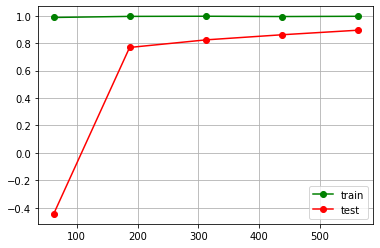

In [54]:
rf_regressor_low_depth = ensemble.RandomForestRegressor(n_estimators = 100, max_depth = 10)

train_sizes, train_scores, test_scores = learning_curve(rf_regressor_low_depth, train_dataset.images, train_dataset.target, 
                                                                       train_sizes=np.arange(0.1,1., 0.2), 
                                                                       cv=3, scoring='r2')

pylab.grid(True)
pylab.plot(train_sizes, train_scores.mean(axis = 1), 'g-', marker='o', label='train')
pylab.plot(train_sizes, test_scores.mean(axis = 1), 'r-', marker='o', label='test')

pylab.legend(loc='lower right')

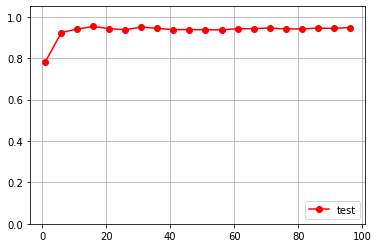

In [73]:
n_est = [i for i in range(1, 100, 5)]
err_ot_n = []
for i in range(1, 100, 5):
    rf_regressor_low_depth = ensemble.RandomForestRegressor(n_estimators = i, max_depth = 10)
    err_ot_n.append(cross_val_score(rf_regressor_low_depth, train_dataset.images, train_dataset.target, cv = 10).mean())
pylab.grid(True)
pylab.plot(n_est, err_ot_n, 'r-', marker='o', label='test')
pylab.ylim((0, 1.05))
pylab.legend(loc='lower right')

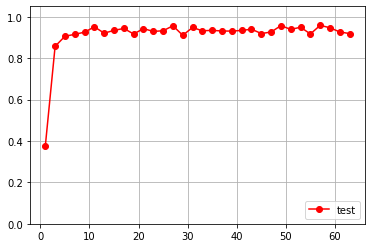

In [74]:
n_est = [i for i in range(1, 64, 2)]
err_ot_n = []
for i in range(1, 64, 2):
    rf_regressor_low_depth = ensemble.RandomForestRegressor(n_estimators = 10, max_depth = i)
    err_ot_n.append(cross_val_score(rf_regressor_low_depth,train_dataset.images, train_dataset.target, cv = 10).mean())
pylab.grid(True)
pylab.plot(n_est, err_ot_n, 'r-', marker='o', label='test')
pylab.ylim((0, 1.05))
pylab.legend(loc='lower right')

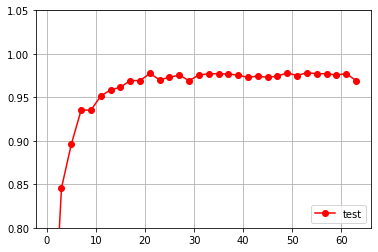

In [75]:
n_est = [i for i in range(1, 64, 2)]
err_ot_n = []
for i in range(1, 64, 2):
    rf_regressor_low_depth = ensemble.RandomForestRegressor(n_estimators = 40, max_depth = 40, random_state = 1, max_features = i)
    err_ot_n.append(cross_val_score(rf_regressor_low_depth,train_dataset.images, train_dataset.target, cv = 10).mean())
pylab.grid(True)
pylab.plot(n_est, err_ot_n, 'r-', marker='o', label='test')
pylab.ylim((0.8, 1.05))
pylab.legend(loc='lower right')

In [122]:
rf_regressor_low_depth = ensemble.RandomForestRegressor(n_estimators = 100, max_depth = 150, max_features = 100)

In [123]:
rf_regressor_low_depth.fit(train_dataset.images, train_dataset.target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=150,
                      max_features=100, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [124]:
predicted = rf_regressor_low_depth.predict(test_dataset.images)

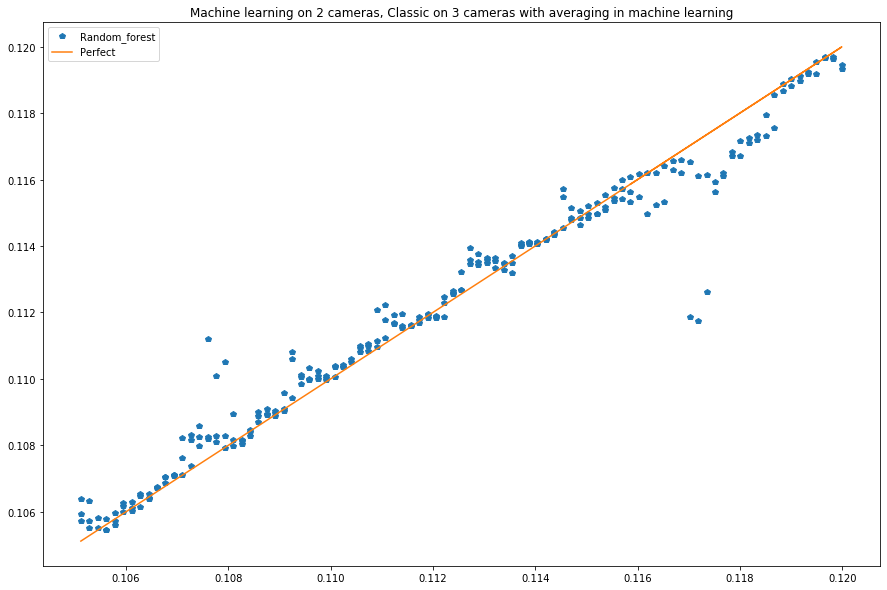

In [125]:
fig = plt.figure(figsize = (15, 10))
plt.plot(test_dataset.target, predicted, "p", label = "Random_forest")
plt.plot(test_dataset.target, test_dataset.target, label = "Perfect")
# plt.plot(y_np, pred_np, '+', label = "Machine Learning") 
plt.title("Machine learning on 2 cameras, Classic on 3 cameras with averaging in machine learning")
plt.legend()

# XGBOOST

In [128]:
from sklearn import ensemble , metrics 
from sklearn.model_selection import cross_val_score, learning_curve
import numpy as np
import pandas as pd
import xgboost as xgb

In [131]:
%%time
n_trees = [1] + [i for i in range(10, 55, 5)] 

scoring = []
for n_tree in n_trees:
    estimator = ensemble.RandomForestRegressor(n_estimators = n_tree, min_samples_split=5)
    score = cross_val_score(estimator, train_dataset.images, train_dataset.target, 
                                             scoring = "r2", cv = 3)    
    scoring.append(score)
scoring = np.asmatrix(scoring)

CPU times: user 11.9 s, sys: 10.4 ms, total: 11.9 s
Wall time: 11.9 s


In [132]:
scoring

matrix([[0.78022901, 0.5539474 , 0.77705754],
        [0.92108054, 0.9775862 , 0.76790093],
        [0.90790905, 0.9796997 , 0.77292549],
        [0.94278362, 0.9768282 , 0.81498494],
        [0.92196847, 0.97077308, 0.80396471],
        [0.91791955, 0.96831977, 0.81739827],
        [0.92414163, 0.97441304, 0.81135322],
        [0.93332077, 0.98013944, 0.81291742],
        [0.91982854, 0.97494173, 0.811765  ],
        [0.9392939 , 0.96611515, 0.80043835]])

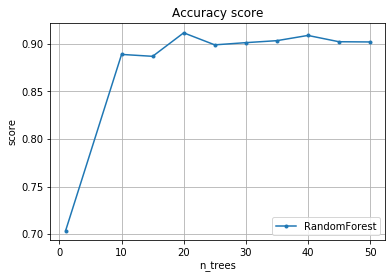

In [133]:
pylab.plot(n_trees, scoring.mean(axis = 1), marker='.', label='RandomForest')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('Accuracy score')
pylab.legend(loc='lower right')

In [140]:
%%time
xgb_scoring = []
for n_tree in n_trees:
    estimator = xgb.XGBRegressor(learning_rate=1, max_depth=5, n_estimators=n_tree, min_child_weight=3)
    score = cross_val_score(estimator, train_dataset.images, train_dataset.target, 
                                             scoring = 'r2', cv = 3)    
    xgb_scoring.append(score)
xgb_scoring = np.asmatrix(xgb_scoring)

[03:23:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:23:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:23:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:23:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:23:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:23:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:23:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:23:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:23:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [141]:
xgb_scoring

matrix([[-0.06995292, -0.00347066, -0.04650664],
        [ 0.89422266,  0.98713141,  0.68293662],
        [ 0.89422266,  0.98713141,  0.68293662],
        [ 0.89422266,  0.98713141,  0.68293662],
        [ 0.89422266,  0.98713141,  0.68293662],
        [ 0.89422266,  0.98713141,  0.68293662],
        [ 0.89422266,  0.98713141,  0.68293662],
        [ 0.89422266,  0.98713141,  0.68293662],
        [ 0.89422266,  0.98713141,  0.68293662],
        [ 0.89422266,  0.98713141,  0.68293662]])

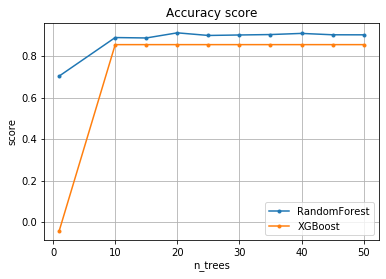

In [142]:
pylab.plot(n_trees, scoring.mean(axis = 1), marker='.', label='RandomForest')
pylab.plot(n_trees, xgb_scoring.mean(axis = 1), marker='.', label='XGBoost')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('Accuracy score')
pylab.legend(loc='lower right')

In [240]:
estimator = xgb.XGBRegressor(learning_rate=1.01, max_depth=120, n_estimators=100, min_child_weight=5)
estimator.fit(train_dataset.images, train_dataset.target)

[03:29:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=1.01, max_delta_step=0,
             max_depth=120, min_child_weight=5, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [241]:
predicted = estimator.predict(test_dataset.images)

In [23]:
fig = plt.figure(figsize = (15, 10))
plt.plot(test_dataset.target, predicted, "p", label = "XGBOOST")
plt.plot(test_dataset.target, test_dataset.target, label = "Perfect")
# plt.plot(y_np, pred_np, '+', label = "Machine Learning") 
plt.title("Machine learning on 3 cameras, Classic on 3 cameras with averaging in machine learning")
plt.legend()

SyntaxError: invalid syntax (<ipython-input-23-eb8be8096802>, line 6)

In [24]:
import numpy as np

In [27]:

prediction = []

In [28]:
prediction.append([1,2,3,4,5])
prediction.append([6,7,8,9,10])
prediction.append(np.array([11,12,13,14,15]))
prediction.append([16,17,18,19,20])

In [29]:
prediction = np.array(prediction)

In [32]:
prediction.T[0]

array([ 1,  6, 11, 16])

In [33]:
params_tree = {"max_size": 1,
               "min_size": 0.5,
               "min_features" : 0.5,
               "max_features" : 1,
               "lr" = [1.01, 1, 0.9, 0.8], 
               "max_depth" = [120, 150, 100], 
               "n_estimators" = [100, 150, 50]
}

SyntaxError: invalid syntax (<ipython-input-33-091dccde7483>, line 5)